# <p style="text-align: center;">Exploring Manifolds with Flow Models</p>

![Picture](https://github.com/TimHenry1995/gyoza/blob/develop/docs/images/Manifold%20s_maxchematic.png?raw=true)

### Introduction
In this work, manifolds in the two dimensional plane are explored with flow models. The goal is to disentangle the factors underlying the shape of the manifolds. As the manifolds themselves are one-dimensional objects, there will be one factor for the position along the manifold and another factor for the deviation from the manifold in the form of noise. The model responsible for this disentanglement shall be flexible to capture complicated patterns in the point cloud. It shall also be invertible such that walking along the manifold in disentangled space can be translated back to walking along the manifold in the original space. The family of flow models is selected here.
 
### Approach
Throughout this interactive notebook, several case studies will be conducted to investigate the suitability of flow models for manifold disentanglement in the two dimensional plane. The case studies are constructed to test particular abilities of the model, including rotation, non-linear stretching and discontinuities. In every case study, data will be generated and a model will be calibrated. The results are evaluated quantitatvely and discussed. The reader is encouraged to change experimental configurations where indicated by code comments to verify the observations made throughout this notebook.

### Notation
The overall objective in each case study will be to develop an invertible model $T$ that maps from a point-cloud $Z$ in an arbitrary $\mathbb{R}^2$ space to a disentangled point-cloud $\tilde{Z}$ in $\mathbb{R}^2$. The below table collects all terms that carry special meaning here.

| Term | Definition | 
| --- | --- |
| $M \in \mathbb{N}, m \in \mathbb{N} < M$ | The number of instances $M$ with index $m$ that are shown to the model $T$ for calibration and evaluation. | 
| $F \in \mathbb{N}, k \in \mathbb{N} < F$ | The number of factors F with index $k$. By convention, $k=0$ is chosen as residual factor. Here, $k=1$ is chosen to represent the position along the manifold (see $s$). Here, $F$ is thus chosen to be $2$. |
| $s \in \mathbb{R}, S \in \mathbb{R}^{M,1}$ | The position s along the manifold used to supervise the model $T$ to associate an input $z$ with an output $s$ along factor $k=1$. It is collected with other positions in $S$. |
| $N \in \mathbb{N}, n \in \{0,1,...,N-1\}$ | The dimensionality of $z$ and $\tilde{z}$, here chosen to be $2$. |
| $z \in \mathbb{R}^N, Z \in \mathbb{R}^{M \times N}$ | An instance $z$ of the input space, collected with other instances in point cloud $Z$. |
| $y \in \mathbb{R}^F, Y \in \mathbb{R}^{M \times F} $| The target for each factor, i.e. class labels in the categorical case or scores in the continuous case as used here (see $s$). | 
| $\tilde{z} = T(z), z = T^{-1}(\tilde{z}) \in \mathbb{R}^{N} \mapsto \mathbb{R}^{N}$ | A transformation $T$ (and its inverse $T^{-1}$) that disentangles $Z$ into $F$ factors, each having their dimensionality $N_k$, such that $\sum_{k=0}^{K-1} N_k = N$. |
| $\tilde{z} \in \mathbb{R}^N, \tilde{z}_k \in \mathbb{R}^{N_k}, \tilde{Z} \in \mathbb{R}^{M \times N}$ | The disentangled representation of point cloud $Z$ with factor $k=0$ along the first dimension of $N$ and $k=1$ along the second dimension of N. |
| $z_{ab} \in \mathbb{R}^{2 \times N}, Z_{ab} \in \mathbb{R}^{M \times 2 \times N}$ | A pair of instances $z$, called z_{ab}, where the axis with $2$ entries is the pair axis. It is collected along with other pairs in $Z_{ab}$ and provided to model $T$ during calibration. |
| $y_{ab} \in [0,1]^{F}, Y_{ab} \in \mathbb{R}^{M \times F}$ | The similarity of a pair of instances (see $z_{ab}$) provided in the range from 0 to 1 (inclusive) for each factor . It is collected along with other similarities in $Y_{ab}$ and used to supervise model $T$ during calibration. Note: For the residual factor the similarity is usually not known and here set to 0. |

Naming conventions:
- Lowercase letters are used to denote indices (e.g. $n,m$), scalars (e.g. $s$) or vectors (e.g. $z, \tilde{z}$).
- Uppercase letters are used to denote totals (e.g. $N,M$) or collections of instances (e.g. $Z, \tilde{Z}, S$).


# Preparations

### Package Management

In [1]:
# Import modules
import importlib
import tensorflow as tf
tf.keras.backend.set_floatx('float64') # If reconstruction precision is too low, increase the precision here
from gyoza.modelling import flow_layers as mfl
from gyoza.modelling import masks as gmm
from gyoza.modelling import standard_layers as msl
from gyoza.utilities import math as gum
import os
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
from typing import List
from gyoza.modelling import data_iterators as mdis
import shutil
import random
from typing import Callable, Tuple
plt.rcParams["font.family"] = "Times New Roman"

2023-07-24 13:02:48.674069: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Reload custom modules
importlib.reload(mfl)
importlib.reload(gmm)
importlib.reload(msl)
importlib.reload(gum)
importlib.reload(mdis)

<module 'gyoza.modelling.data_iterators' from '/Users/timdick/opt/anaconda3/envs/gyoza_environment/lib/python3.9/site-packages/gyoza/modelling/data_iterators.py'>

### Configuration

In [3]:
tf.keras.backend.set_floatx('float64') # If reconstruction precision is too low, increase the precision here
def reset_random_number_generators(seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

### Data Synthesis

In [19]:
def create_data_set(S: np.array, manifold_function_raw: Callable, noise_strength: float) -> Tuple[np.array, np.array]:
    """Creates a data set by passing the position ``S`` along the manifold through the ``manifold_function_raw`` and adding Gaussian noise to 
    each dimension. That noise is centered at zero and has standard devitation ``noise_strength``.

    :param S: The position along the manifold. Shape == [instance_count, 1]
    :type S: np.array
    :param manifold_function_raw: A function that maps from ``S`` to coordinates on the manifold in the real two dimensional plane.
    :type manifold_function_raw: :class:`Callable`
    :param noise_strength: Standard deviation of the noise.
    :type noise_strength: float
    :return: 
        - Z (:class:`numpy.ndarray`) - The collection of points around the manifold. Shape == [instance count, 2].
        - Y (:class:`numpy.ndarray`) - The target for factorization. Here, it is 0 for the residual factor (index 0) and S for the position factor
        (index 1). Shape == [instance count, factor count], where factor count is 2 here.
    """
    # Here the first dimension is zero because deviation from the manifold is pushed to the residual factor. The second dimension is the step along the manifold 
    # Add noise 
    noise_function = lambda x_1, x_2: (x_1 + noise_strength * np.random.normal(scale=noise_strength, size=x_1.shape), x_2 + noise_strength * np.random.standard_normal(size=x_2.shape))
    manifold_function = lambda x: noise_function(*manifold_function_raw(x))

    # Generate data
    Y = np.concatenate([np.zeros([len(S),1]), S[:, np.newaxis]], axis=1) 
    Z_1, Z_2 = manifold_function(S) # Map line s onto manifold in 2D plane
    Z = np.concatenate([Z_1[:,np.newaxis], Z_2[:,np.newaxis]], axis=1)

    # Outputs
    return Z, Y


# Generate equally spaced points along a line
golden_ratio = (1 + 5 ** 0.5) / 2
beta = np.log(golden_ratio)/(np.pi/2) # https://en.wikipedia.org/wiki/Golden_spiral see section on mathematics
s_max = (1*np.sqrt(1+beta**2)/beta)*(np.exp(beta*2*np.pi)-1)/2 # https://www.quora.com/What-is-the-arc-length-of-the-logarithmic-spiral-from-t0-to-t the arc length of the golden spiral for one full rotation
S = np.linspace(-s_max,s_max,1000, dtype=tf.keras.backend.floatx()) # These points are the steps along any manifold

# This function computes the similarity Y_ab
similarity_function = lambda Y_a, Y_b: np.concatenate([np.zeros([Y_a.shape[0],1]), 1 - np.abs(Y_a[:,1:2]-Y_b[:,1:2])/ (np.abs(np.max(S)-np.min(S)))], axis=1)

### Plotting

In [40]:
def plot_instance_pairs(S: np.ndarray, Z_ab: np.ndarray, Y_ab: np.ndarray, manifold_function_raw: Callable, manifold_name: str):
    """Plots pairs of instances along with their similarities and the raw manifold.

    :param S: The position along the manifold. Shape == [instance_count, 1]
    :type S: np.array
    :param Z_ab: The coordinates of the instances to be plotted. Shape is assumed to be [instance count, 2, 2] where the 2 at axis 1 enumerates
        the two instances of the pair and the 2 at axis 2 enumerates their coordinates in 2 dimensional space.
    :type Z_ab: :class:`numpy.ndarray`
    :param Y_ab: The similarities of the ``Z_ab`` instances. Shape is assumed to be [instance count, 2], where the 2 at axis 1 is the factor count.
    :type Y_ab: :class:`numpy.ndarray`
    :param manifold_function_raw: A function that takes as input the position along the manifold and provides as output the two coordinates that
        are associated with that position along the manifold.
    :type manifold_function_raw: Callable
    :param manifold_name: A name assigned to the manifold that is used as a label in the plot.
    :type manifold_name: str
    """

    # Construct figure
    plt.figure(figsize=(5,5)); plt.title("Pairs Of Instances And Their Factorized Similarities")
        
    # Plot instance pairs
    plt.scatter(Z_ab[:,0,0], Z_ab[:,0,1]) # Instances a
    plt.scatter(Z_ab[:,1,0], Z_ab[:,1,1]) # Instances b

    # Plot manifold
    plt.scatter(*manifold_function_raw(S), color='gray', marker='.', s=1)

    # Label current plots
    plt.legend(['z_a','z_b',rf'${manifold_name}$'])

    # Plot lines that connect the two instances of a pair
    s_max = np.max(S)
    for i in range(Z_ab.shape[0]): # Iterate instances
        plt.plot([Z_ab[i,0,0], Z_ab[i,1,0]], [Z_ab[i,0,1], Z_ab[i,1,1]], '--', color='black')
        plt.text(Z_ab[i,1,0]+0.5, Z_ab[i,1,1], 's = ' + str(np.round(Y_ab[i,1], 2))) # Label for their similarity
    plt.ylim(-s_max/0.8,s_max/0.8); plt.xlim(-s_max/0.8,s_max/0.8)
    plt.show()

# Case Study 1: Rotation

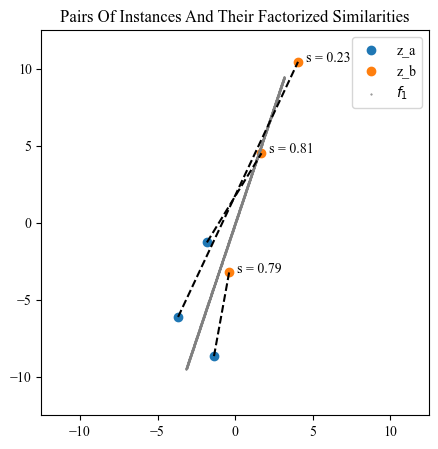

In [49]:
# Set up the raw manifold function
rise = np.sign(np.arcsinh(s_max)) * np.cosh(np.arcsinh(s_max)) - np.sign(s_max)
run = np.arcsinh(s_max)
theta=np.arccos((rise/ run) / np.sqrt(run**2 + rise**2))
f = lambda S: gum.rotate(xs=S, ys=0*S, theta=theta) # this theta leads to same slope as the cosh function on s

# Generate a dataset
reset_random_number_generators(seed=2)
Z, Y = create_data_set(S=S, manifold_function_raw=f, noise_strength=1.0)

# Plot pairs of instances
iterator = mdis.volatile_factorized_pair_iterator(X=Z, Y=Y, batch_size=3, similarity_function=similarity_function)
Z_ab, Y_ab = next(iterator)

plot_instance_pairs(S=S, Z_ab=Z_ab, Y_ab=Y_ab, manifold_function_raw=f, manifold_name='f_1')

# Case Study 2: Twist

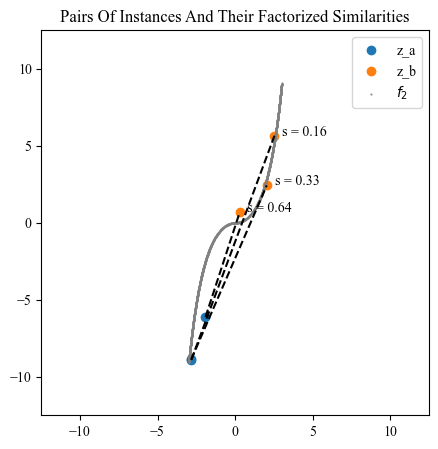

In [42]:
# Set up the raw manifold function
f = lambda S: (np.arcsinh(S), np.sign(np.arcsinh(S)) * np.cosh(np.arcsinh(S)) - np.sign(S))

# Generate a dataset
reset_random_number_generators(seed=957)
Z, Y = create_data_set(S=S, manifold_function_raw=f, noise_strength=0.5)

# Plot pairs of instances
iterator = mdis.volatile_factorized_pair_iterator(X=Z, Y=Y, batch_size=3, similarity_function=similarity_function)
Z_ab, Y_ab = next(iterator)

plot_instance_pairs(S=S, Z_ab=Z_ab, Y_ab=Y_ab, manifold_function_raw=f, manifold_name='f_2')

# Case Study 3: Discontinuity

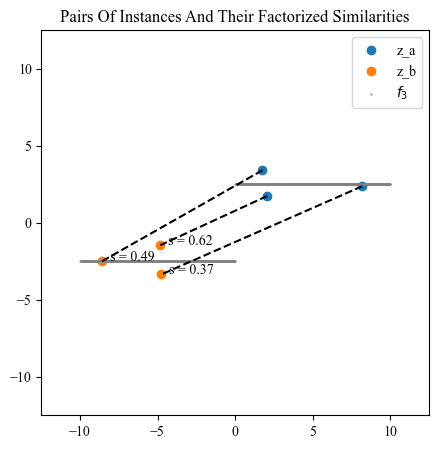

In [43]:
# Set up the raw manifold function
f = lambda S: (S, s_max*np.sign(S)/4)

# Generate a dataset
reset_random_number_generators(seed=253)
Z, Y = create_data_set(S=S, manifold_function_raw=f, noise_strength=0.5)

# Plot pairs of instances
iterator = mdis.volatile_factorized_pair_iterator(X=Z, Y=Y, batch_size=3, similarity_function=similarity_function)
Z_ab, Y_ab = next(iterator)

plot_instance_pairs(S=S, Z_ab=Z_ab, Y_ab=Y_ab, manifold_function_raw=f, manifold_name='f_3')

# Case Study 4: Overlap

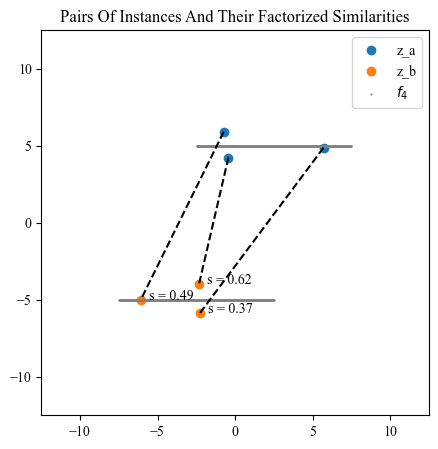

In [44]:
# Set up the raw manifold function
def f(S):
    half_1 = S[np.where(S <  0)]
    half_2 = S[np.where(0 <= S)]
    s_max = np.max(S)
    Z_1 = np.concatenate([half_1, half_2 - s_max/2]) + 1*s_max/4
    Z_2 = np.array([1*s_max/2]* len(half_1) + [3*s_max/2] * len(half_2)) - s_max

    return Z_1, Z_2

# Generate a dataset
reset_random_number_generators(seed=253)
Z, Y = create_data_set(S=S, manifold_function_raw=f, noise_strength=0.5)

# Plot pairs of instances
iterator = mdis.volatile_factorized_pair_iterator(X=Z, Y=Y, batch_size=3, similarity_function=similarity_function)
Z_ab, Y_ab = next(iterator)

plot_instance_pairs(S=S, Z_ab=Z_ab, Y_ab=Y_ab, manifold_function_raw=f, manifold_name='f_4')


# Case Study 5: Loop

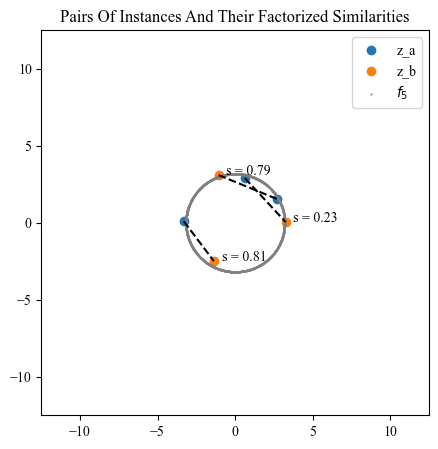

In [67]:
# Set up the raw manifold function
f = lambda S: ((2*s_max/(2*np.pi))*np.cos((S+s_max)*(2*np.pi)/(2*s_max)), (2*s_max/(2*np.pi))* np.sin((S+s_max)*(2*np.pi)/(2*s_max)))

# Generate a dataset
reset_random_number_generators(seed=2)
Z, Y = create_data_set(S=S, manifold_function_raw=f, noise_strength=0.3)

# Plot pairs of instances
iterator = mdis.volatile_factorized_pair_iterator(X=Z, Y=Y, batch_size=3, similarity_function=similarity_function)
Z_ab, Y_ab = next(iterator)

plot_instance_pairs(S=S, Z_ab=Z_ab, Y_ab=Y_ab, manifold_function_raw=f, manifold_name='f_5')

# Case Study 6: Spiral

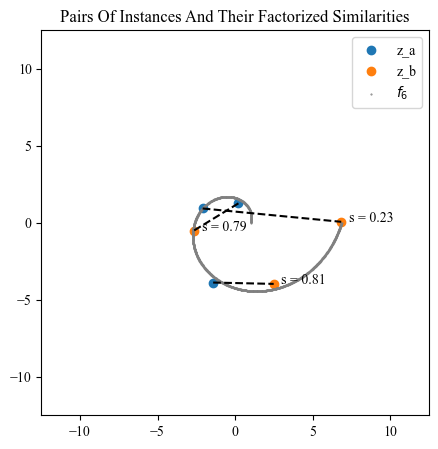

In [69]:
# Set up the raw manifold function
f = lambda S: gum.logarithmic_spiral(xs=np.log((S+s_max)/(1*np.sqrt(1+beta**2)/beta)+1)/beta, alpha=1, beta=beta) # https://www.quora.com/What-is-the-arc-length-of-the-logarithmic-spiral-from-t0-to-t

# Generate a dataset
reset_random_number_generators(seed=2)
Z, Y = create_data_set(S=S, manifold_function_raw=f, noise_strength=0.3)

# Plot pairs of instances
iterator = mdis.volatile_factorized_pair_iterator(X=Z, Y=Y, batch_size=3, similarity_function=similarity_function)
Z_ab, Y_ab = next(iterator)

plot_instance_pairs(S=S, Z_ab=Z_ab, Y_ab=Y_ab, manifold_function_raw=f, manifold_name='f_6')

# Model Creation

In [ ]:
def create_network(seed) -> mfl.FlowLayer:
    reset_random_number_generators(seed=seed)
    dimensionality = 2
    compute_coupling_parameters_1 = msl.BasicFullyConnectedNet(latent_dimension_count=4*dimensionality, output_dimension_count=dimensionality, depth=3)
    mask_1 = gmm.CheckerBoard(axes=[1], shape=[dimensionality])
    compute_coupling_parameters_2 = msl.BasicFullyConnectedNet(latent_dimension_count=4*dimensionality, output_dimension_count=dimensionality, depth=3)
    mask_2 = gmm.CheckerBoard(axes=[1], shape=[dimensionality])
    compute_coupling_parameters_3 = msl.BasicFullyConnectedNet(latent_dimension_count=4*dimensionality, output_dimension_count=dimensionality, depth=3)
    mask_3 = gmm.CheckerBoard(axes=[1], shape=[dimensionality])
    compute_coupling_parameters_4 = msl.BasicFullyConnectedNet(latent_dimension_count=4*dimensionality, output_dimension_count=dimensionality, depth=3)
    mask_4 = gmm.CheckerBoard(axes=[1], shape=[dimensionality])
    
    network = mfl.SupervisedFactorNetwork(sequence=[
        mfl.AdditiveCoupling(axes=[1], shape=[dimensionality], compute_coupling_parameters=compute_coupling_parameters_1, mask=mask_1), 
        mfl.Heaviside(axes=[1], shape=[dimensionality]),
        mfl.AdditiveCoupling(axes=[1], shape=[dimensionality], compute_coupling_parameters=compute_coupling_parameters_2, mask=mask_2), 
        mfl.Heaviside(axes=[1], shape=[dimensionality]),
        mfl.Reflection(axes=[1], shape=[dimensionality], reflection_count=2),
        mfl.AdditiveCoupling(axes=[1], shape=[dimensionality], compute_coupling_parameters=compute_coupling_parameters_3, mask=mask_3), 
        mfl.Heaviside(axes=[1], shape=[dimensionality]),
        mfl.AdditiveCoupling(axes=[1], shape=[dimensionality], compute_coupling_parameters=compute_coupling_parameters_4, mask=mask_4), 
        mfl.Heaviside(axes=[1], shape=[dimensionality]),
        mfl.ActivationNormalization(axes=[1], shape=[dimensionality])
        ],
        dimensions_per_factor=[1,1]) # One dimension for the residual factor (index 0) and one for the manifold proximity (index 1)

    return network

network = create_network(62) #60, 61

network(X_a_b[:,0,:]) # Pass a representative sample through the network. Needed for initialization of some layers
print("For the these 3 X_a input instances:")
print(X_a_b[:3,0,:]) # 0 selects X_a
print("\nthe model provides this initial decomposition ")
print(network(X_a_b[:3,0,:])) # 0 selects X_a
print("\nand this is the reconstruction error (should be almost 0)")
print(network.invert(network(X_a_b[:3,0,:])) - X_a_b[:3,0,:])  # 0 selects X_a


For the these 3 X_a input instances:
tf.Tensor(
[[-1.81577727 -1.96995906]
 [ 6.86171525  0.06864957]
 [-2.73360134 -1.48054351]], shape=(3, 2), dtype=float64)

the model provides this initial decomposition 
tf.Tensor(
[[ 0.15318597 -0.72957505]
 [ 1.82545631  1.83763745]
 [-0.49774723 -0.67818949]], shape=(3, 2), dtype=float64)

and this is the reconstruction error (should be almost 0)
tf.Tensor(
[[ 6.66133815e-16  8.88178420e-16]
 [-8.88178420e-16  2.22044605e-16]
 [ 4.44089210e-16  4.44089210e-16]], shape=(3, 2), dtype=float64)


# Model Calibration

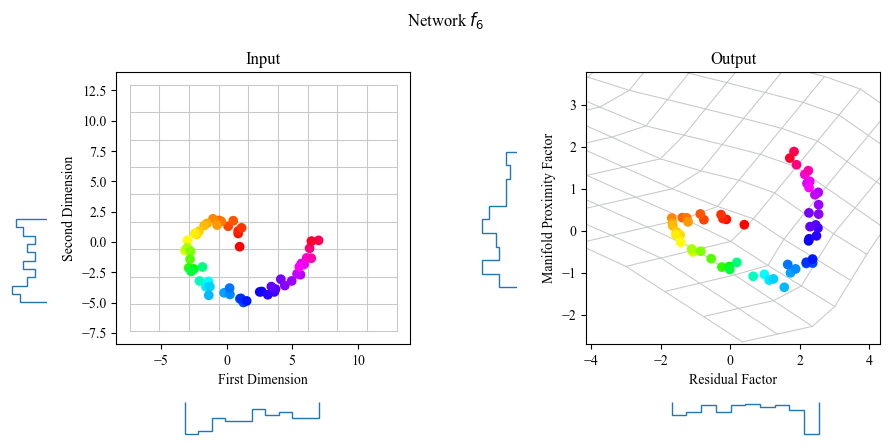

In [ ]:
def plot_input_output(network, s_range, f, title):
    # Sample from manifold to illustrate distortion of data
    s = np.linspace(s_range[0], s_range[1], len(gum.color_palette)) # Each point will receive its own color
    x_1, x_2 = f(s)
    
    # Create gridlines to illustrate distortion of surrounding space
    points_per_line = 10
    min_x_1 = np.min(x_1); max_x_1 = np.max(x_1); mean_x_1 = np.abs(np.mean(x_1))
    min_x_2 = np.min(x_2); max_x_2 = np.max(x_2); mean_x_2 = np.abs(np.mean(x_2))
    
    if (np.abs(max_x_1 - min_x_1) < np.abs(max_x_2 - min_x_2)):
        x_2_grid = np.linspace(min_x_2 - np.abs(mean_x_2 - min_x_2), max_x_2 + np.abs(mean_x_2-max_x_2), points_per_line)
        h_x_1, h_x_2 = np.meshgrid(x_2_grid, x_2_grid) # horizontal line coordinates
        v_x_2, v_x_1 = np.meshgrid(x_2_grid, x_2_grid) # vertical line coordinates
    else:
        
        x_1_grid = np.linspace(min_x_1 - np.abs(mean_x_1-min_x_1), max_x_1 + np.abs(mean_x_1-max_x_1), points_per_line)
        h_x_1, h_x_2 = np.meshgrid(x_1_grid, x_1_grid) # horizontal line coordinates
        v_x_2, v_x_1 = np.meshgrid(x_1_grid, x_1_grid) # vertical line coordinates

    # Plot
    fig, axs = plt.subplots(2,4,figsize=(9,4.5), gridspec_kw={'height_ratios': [4, 0.5], 'width_ratios':[0.5,4,0.5,4]})
    # X
    # Plot joint distributions
    plt.suptitle(title)
    plt.subplot(2,4,2); plt.title("Input")
    # Gridlines
    for l in range(points_per_line): plt.plot(h_x_1[l,:], h_x_2[l,:], color='#C5C9C7', linewidth=0.75)
    for l in range(points_per_line): plt.plot(v_x_1[l,:], v_x_2[l,:], color='#C5C9C7', linewidth=0.75)
    # Data
    plt.scatter(x_1, x_2, c=gum.color_palette/255.0, zorder=3); plt.xlabel("First Dimension"); plt.ylabel("Second Dimension")
    X_x_lim = plt.gca().get_xlim(); X_y_lim = plt.gca().get_ylim() # Use these for marginal distributions
    
    # Z
    plt.subplot(2,4,4); plt.title("Output")
    Z = network(tf.concat([x_1[:,np.newaxis], x_2[:,np.newaxis]], axis=1))
    H_z = network(tf.concat([np.reshape(h_x_1, [-1])[:,np.newaxis], np.reshape(h_x_2, [-1])[:,np.newaxis]], axis=1))
    V_z = network(tf.concat([np.reshape(v_x_1, [-1])[:,np.newaxis], np.reshape(v_x_2, [-1])[:,np.newaxis]], axis=1))
    
    # Gridlines
    for l in range(points_per_line): plt.plot(H_z[l*points_per_line:(l+1)*points_per_line,0], H_z[l*points_per_line:(l+1)*points_per_line,1], color='#C5C9C7', linewidth=0.75)
    for l in range(points_per_line): plt.plot(V_z[l*points_per_line:(l+1)*points_per_line,0], V_z[l*points_per_line:(l+1)*points_per_line,1], color='#C5C9C7', linewidth=0.75)
    # Data
    plt.scatter(Z[:,0], Z[:,1], c=gum.color_palette/255.0, zorder=3); plt.xlabel('Residual Factor'); plt.ylabel('Manifold Proximity Factor')
    Z_min = np.min(Z, axis=0); Z_max = np.max(Z, axis=0); Z_mean = np.mean(Z, axis=0)
    Z_x_lim = (Z_min[0] - np.abs(Z_mean[0] - Z_min[0]), Z_max[0] + np.abs(Z_mean[0] - Z_max[0])); 
    Z_y_lim = (Z_min[1] - np.abs(Z_mean[1] - Z_min[1]), Z_max[1] + np.abs(Z_mean[1] - Z_max[1])); 
    plt.xlim(*Z_x_lim); plt.ylim(*Z_y_lim)
    
    # Plot marginal distributions
    # X
    plt.subplot(2,4,6)
    plt.hist(x_1, histtype='step'); plt.xlim(X_x_lim); plt.gca().invert_yaxis(); plt.axis('off')
    plt.subplot(2,4,1)
    plt.hist(x_2, orientation='horizontal', histtype='step'); plt.ylim(X_y_lim); plt.gca().invert_xaxis(); plt.axis('off')
    
    # Z
    plt.subplot(2,4,8)
    plt.hist(Z[:,0], histtype='step'); plt.gca().invert_yaxis(); plt.xlim(Z_x_lim); plt.axis('off')
    plt.subplot(2,4,3)
    plt.hist(Z[:,1], orientation='horizontal', histtype='step'); plt.ylim(Z_y_lim); plt.gca().invert_xaxis(); plt.axis('off')
    
    # Make other subplots invisible
    plt.subplot(2,4,5); plt.axis('off')
    plt.subplot(2,4,7); plt.axis('off')

    plt.tight_layout()
    plt.show() 
 
plot_input_output(network, s_range = [np.min(s), np.max(s)], f=manifold_function, title="Network " + r"${}$".format(manifold_name))

In [ ]:
network.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))
epoch_count = 50
batch_size = 128
reset_random_number_generators(568)
for e in range(epoch_count):
    iterator = mdis.volatile_factorized_pair_iterator(X=X, Y=Y, batch_size=batch_size, similarity_function=similarity_function)
    for batch in iterator:
        loss = network.train_step(data=batch)
        print(loss.numpy())

7.964419901557926
7.3810742178600455
7.054668723805394
7.159183440673247
6.892337561972176
6.708771226934539
6.539764741243099
6.851190995522037
6.583591381839643
6.41526154964117
6.3243357269667815
6.324473145591815
6.446051949650979
6.3743298124448415
6.517432596738964
6.3608359572814965
6.337930303795634
6.318685366005223
6.292089636507114
6.254033656738591
6.311354271380292
6.267656711161088
6.215743414549539
6.281160361944534
6.283203587188652
6.3583732642156985
6.304575865195668
6.322890965161594
6.159081683988636
6.186010885213487
6.26875082398767
6.1452669866044864
6.327685536130834
6.2373584606351855
6.216579245540991
6.034684082497317
6.161422535698055
6.075960351446588
6.117071637020475
6.1189566832337485
6.068944852306376
6.0375612495212465
6.111847606350715
6.142253019080176
6.14242626476385
6.149396898133068
6.226467694087361
6.084754882567305
6.269075291345516
6.079007246920765
6.143701963541272
6.090853490508979
6.134097591070349
6.116278155636423
6.116803477853188
6.16

[5.517285152944359]
[5.500130361979565]
[5.507636344801213]
[5.584058097904183]
[5.373987060545219]
[5.383378213805081]
[5.552583466264153]
[5.575324150043498]
[5.39754262303724]
[5.403241637029571]
[5.8380849071260315]
[5.751026514872176]
[5.584351469444687]
[5.311710711102263]
[5.307308865634877]
[5.237889251652575]
[5.326843113373113]
[5.365511063404162]
[5.378312273111483]
[5.339165134596485]
[5.338808579841418]
[5.373508771155967]
[5.548711955997895]
[6.035667352018805]
[5.475067239156471]
[5.237494724897434]
[5.517632491031593]
[5.228133409483276]
[5.2566744499777815]
[5.29890576091374]
[5.3257203177484564]
[5.379757342044126]
[5.3511734120081105]
[5.752008535613221]
[5.345222884674369]
[5.225889189698501]
[5.096066896891311]
[5.265985243476765]
[5.314063003328011]
[5.723858517352087]
[5.3716206078189455]
[5.044738896608437]
[5.186631213518664]
[5.220402884545559]
[5.2806698739477955]
[5.154109414242971]
[5.415026609612637]
[4.9993899091153935]
[5.438748300831767]
[5.268467362471

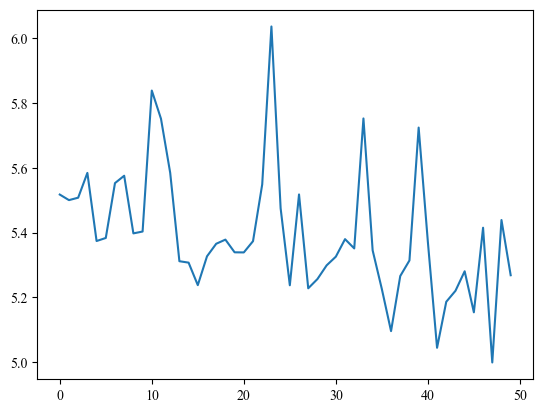

In [ ]:
#network.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))
reset_random_number_generators(seed=78)
iterator = mdis.VolatileFactorizedPairIterator(X=X, Y=Y, batch_size=512, similarity_function=similarity_function)
epoch_losses = network.fit(iterator=iterator, epoch_count=50)
plt.figure()
plt.plot(epoch_losses)
plt.show()   

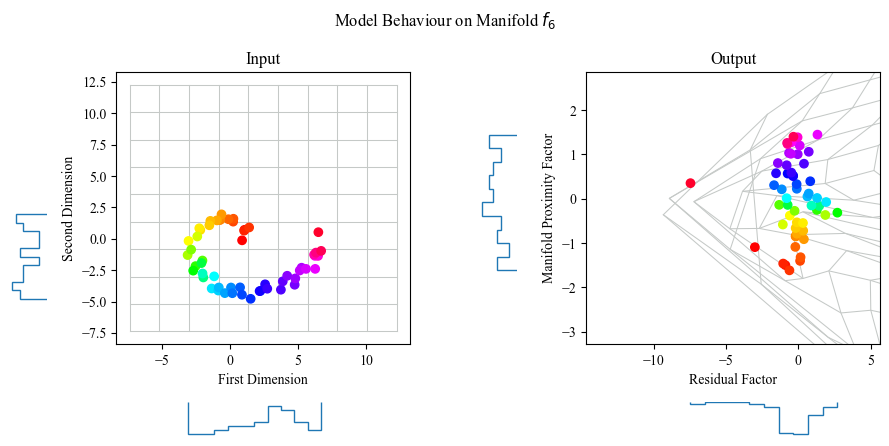

In [ ]:
plot_input_output(network, s_range = [np.min(s), np.max(s)], f=manifold_function, title="Model Behaviour on Manifold " + r"${}$".format(manifold_name))

# Model Testing

# Model Saving

xx -2rxy + yy = (y-rx)(y-rx) = yy - yrx -rxy +rrxx = yy -2rxy + xxrr